# Assignment-1 (KNN Classifier)-Part-A
## Handwritten digit recognition
In this assignment part-A, we will use the built-in library ``sklearn`` to use KNN classifier.

## The MNIST dataset
`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The training set contains 60,000 examples and the test set contains 10,000 examples. In this assignment we will further split the training set to take out 12,000 examples as a validation step.

In [1]:
%matplotlib inline
import gzip, os
import numpy as np
import matplotlib.pyplot as plt
import time
from urllib.request import urlretrieve
import pandas as pd 

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [69]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [4]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (60000, 784)
Number of training labels:  60000
Testing dataset dimensions:  (10000, 784)
Number of testing labels:  10000


In [5]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test set distribution:
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


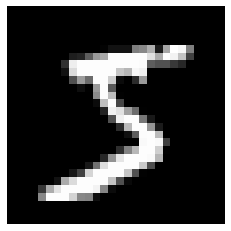

Label 5


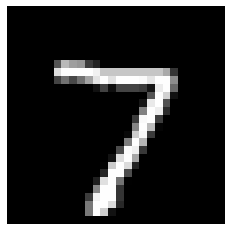

Label 7


In [6]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## Splitting the Train data to Train and Validate Sets

In [7]:
from sklearn.model_selection import train_test_split
trainx, valx, trainy, valy = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)
# since there's nothing here to make me put my code, I'm assuming that I don't have to do anything 

## 1. K-Nearest neighbor classifier--Brute Force Approach

Use the built-in KNN classifier to perform handwritten digit classification task. Please keep in mind that any hyper-parameter selection shall be performed on the independent validation set and not on the test set. You need to study the KNeighborsClassifier documentation to understand how to use the api with different parameters. In this set of experiments, you need to select 'brute' for the **algorithm** parameter. Record the error rates on the test set and the cpu time taken for evaluation.

**Note:** Here you don't have to implement the KNN classifier but you just need to use it from ``sklearn`` library.

In [51]:
#when choosing K I should've probably used a range from 1 to sqrt of N where N is the number of samples,
#but for the sake of time I used a small range 

from sklearn.neighbors import KNeighborsClassifier
### START CODE HERE ###
def accuracy(y_pred, valy):
    if len(y_pred) != len(valy):
        print("Error, different Sizes!")
        return None
    correct = np.sum(y_pred == valy)
    accuracy = correct / len(y_pred)
    return accuracy
Ks = [k for k in range(1, 10) if k % 2 != 0]
values_auto = []
Accuracies_auto = []
Times_auto = []
for k in Ks:
    
    startTime = time.process_time()
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(trainx, trainy)
    y_pred = neigh.predict(valx)
    acc = accuracy(y_pred, valy)
    endTime = time.process_time()
    allTime = endTime - startTime
    values_auto.append(k)
    Accuracies_auto.append(acc)
    Times_auto.append(allTime)
data_auto = {
    "K" : values_auto,
    "accuracies" : Accuracies_auto,
    "Time" : Times_auto
}
df_auto = pd.DataFrame(data_auto)

### END CODE HERE ###

In [71]:
best_k = values_auto[Accuracies_auto.index(max(Accuracies_auto))]
print("the best K is for accuracy in the Generic KNN:")
print(best_k)
df_auto.head()

neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(trainx, trainy)
y_pred = neigh.predict(test_data)
acc = accuracy(y_pred, test_labels)

print("the accuracy on the test set is: ", acc)

the best K is for accuracy in the Generic KNN:
1
the accuracy on the test set is:  0.9673


## 2. Faster nearest neighbor methods

Performing nearest neighbor classification in the way we have presented requires a full pass through the training set in order to classify a single point. If there are $N$ training points in $\mathbb{R}^d$, this takes $O(N d)$ time.

Fortunately, there are faster methods to perform nearest neighbor look up if we are willing to spend some time preprocessing the training set. `scikit-learn` has fast implementations of two useful nearest neighbor data structures: the _ball tree_ and the _k-d tree_. Record the error rates on the test set and the cpu time taken for evaluation using these two faster methods.

**Note:** You need to select 'ball_tree'or 'kd_tree' for the **algorithm** parameter for ``KNeighborsClassifier`` classifier.

In [11]:
# You can use KNeighborsClassifier with correct values for 'algorithm'
### START CODE HERE ###\
values_ball = []
Accuracies_ball = []
Times_ball = []
values_tree = []
Accuracies_tree = []
Times_tree = []
for k in Ks:
    
    startTime = time.process_time()
    neigh = KNeighborsClassifier(n_neighbors = k, algorithm ="ball_tree")
    neigh.fit(trainx, trainy)
    y_pred = neigh.predict(valx)
    acc = accuracy(y_pred, valy)
    endTime = time.process_time()
    allTime = endTime - startTime
    values_ball.append(k)
    Accuracies_ball.append(acc)
    Times_ball.append(allTime)
data_Ball = {
    "K" : values_ball,
    "accuracies" : Accuracies_ball,
    "Time" : Times_ball
}
df_BallTree = pd.DataFrame(data_Ball)

for k in Ks:
    
    startTime = time.process_time()
    neigh = KNeighborsClassifier(n_neighbors = k, algorithm ="kd_tree")
    neigh.fit(trainx, trainy)
    y_pred = neigh.predict(valx)
    acc = accuracy(y_pred, valy)
    endTime = time.process_time()
    allTime = endTime - startTime
    values_tree.append(k)
    Accuracies_tree.append(acc)
    Times_tree.append(allTime)
data_KD = {
    "K" : values_tree,
    "accuracies" : Accuracies_tree,
    "Time" : Times_tree
}
df_KD = pd.DataFrame(data_KD)
### END CODE HERE ###

In [15]:
display(df_BallTree)
display(df_KD.head())

,K,accuracies,Time
0,1,0.974083,378.296875
1,3,0.972667,382.359375
2,5,0.971500,380.828125
3,7,0.969583,388.703125
4,9,0.967333,381.312500


,K,accuracies,Time
0,1,0.974083,490.640625
1,3,0.972667,491.625000
2,5,0.971500,491.359375
3,7,0.969583,489.250000
4,9,0.967333,491.000000


## 3. Record CPU time and accuracy for all the three approaches in different datasets

Use brute-force, kd-tree, and ball-tree approaches for the following datasets and record the accuracies and cpu time (for evaluation step only). Looking at the results, can you explain it.

Datasets:
1. Abalone Data Set (https://archive.ics.uci.edu/ml/datasets/abalone)
2. Statlog (Landsat Satellite) Data Set (https://archive.ics.uci.edu/ml/datasets/Statlog+(Landsat+Satellite))

**Note:** The datasets are provided as attachement in the assignment as CSV files.

In [56]:
# You can use KNeighborsClassifier with correct values for 'algorithm'
### START CODE HERE ###
satimage = pd.read_csv("186_satimage.csv")
abalone1 = pd.read_csv("Abalone19.csv")
abalone19 = pd.get_dummies(abalone1, columns=['M'], prefix=['OneHot'])
# display(satimage)
# display(abalone19)
sat_X = satimage.drop('1', axis=1)
sat_Y = satimage['1']

abalone_X = abalone19.drop('15', axis=1)
abalone_Y = abalone19['15']
sat_trainx, sat_valx, sat_trainy, sat_valy = train_test_split(sat_X, sat_Y, test_size=0.20, random_state=42)
abalone_trainx, abalone_valx, abalone_trainy, abalone_valy = train_test_split(abalone_X, abalone_Y, test_size=0.20, random_state=42)

def KNN_evaluate(X_train, Y_train, X_val, Y_val):
    Ks = [x for x in range(1, 20) if x % 2 != 0]
    K = []
    acc = [] 
    times = [] 
    temp = []
    models = ['auto', 'KD_Tree', 'Ball_Tree']
    for model in models:
        for k in Ks:
            if model  == 'auto':
                neigh = KNeighborsClassifier(n_neighbors = k)
            elif model == 'KD_Tree': 
                neigh = KNeighborsClassifier(n_neighbors = k, algorithm ="kd_tree")
            elif model == 'Ball_Tree':
                neigh = KNeighborsClassifier(n_neighbors = k, algorithm ="ball_tree")
        
            startTime = time.process_time()
            neigh.fit(X_train, Y_train)
            y_pred = neigh.predict(X_val)
            endTime = time.process_time()
            acc.append(accuracy(y_pred, Y_val))
            K.append(k)
            alltime = endTime - startTime
            times.append(alltime)
            temp.append(model)
        
    data = { 
    "model" : temp,
    "K" : K,
    "Time" : times,
    "accuracy" : acc
        }
    return pd.DataFrame(data)
    
satDF = KNN_evaluate(sat_trainx, sat_trainy, sat_valx, sat_valy)
abaloneDF = KNN_evaluate(abalone_trainx, abalone_trainy, abalone_valx, abalone_valy)

print("Sat prediction results")
display(satDF)
print("abalone prediction results")
display(abaloneDF)






# ### END CODE HERE ###

Sat prediction results


,model,K,Time,accuracy
0,auto,1,1.015625,0.909798
1,auto,3,1.343750,0.929238
2,auto,5,1.593750,0.916796
3,auto,7,1.625000,0.914463
4,auto,9,1.656250,0.919907
5,auto,11,1.546875,0.912131
6,auto,13,1.656250,0.909798
7,auto,15,1.578125,0.909020
8,auto,17,1.687500,0.912908
9,auto,19,1.671875,0.909798


abalone prediction results


,model,K,Time,accuracy
0,auto,1,0.015625,0.205742
1,auto,3,0.046875,0.193780
2,auto,5,0.031250,0.224880
3,auto,7,0.015625,0.235646
4,auto,9,0.031250,0.236842
5,auto,11,0.031250,0.244019
6,auto,13,0.031250,0.245215
7,auto,15,0.015625,0.255981
8,auto,17,0.031250,0.253589
9,auto,19,0.031250,0.273923


The best accuracy with K for SAT data:
model           auto
K                  3
Time         1.34375
accuracy    0.929238
Name: 1, dtype: object
The best K for Abalone data:


In [66]:
print("The best K for Sat data with accuracy and time:")
max_index = satDF['accuracy'].idxmax()
max_row = satDF.loc[max_index]
display(max_row)
print("The best K for Abalone data with accuracy and time:")
max_index = abaloneDF['accuracy'].idxmax()
max_row = abaloneDF.loc[max_index]
display(max_row)

The best K for Sat data with accuracy and time:


model           auto
K                  3
Time         1.34375
accuracy    0.929238
Name: 1, dtype: object

The best K for Abalone data with accuracy and time:


model           auto
K                 19
Time         0.03125
accuracy    0.273923
Name: 9, dtype: object

In [ ]:
'''
the acc for the abalone is pathetic, and I think it's because of the 1-hot-encoding. 
the acc will be the same for all models, the diff is only in the test time and train time as well
'''

## E1. Extra Stuff

You are invited to try some more ideas as extra work like:
1. Instead of using the pixels as features, implement your own features (example: what were presented in the slides) and use them for KNN. You need to keep in mind that if you compute features which have different scales then it is important to scale/normalize the features (discussed in the slides).

## Points to remember

You need to keep in mind the following points:
1. Use numpy arrays and numpy libraries for efficient computations. 